In [1]:
import sys
import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
print(sys.version)

3.4.3 (default, Apr  3 2015, 14:52:06) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]


## Plotting 

To plot our technical indicators we will use a reusabled function `plot`:

In [3]:
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt
    
def plot(stock, overlays = [], subplots = []):
    fig = plt.figure()
    plt.figure(figsize=(14,6))
    plt.rc('axes', color_cycle=['#31a354', '#3182bd', '#e6550d', '#de2d26', '#c51b8a'])

    left, width = 0.1, 2
    
    subplot_bottom = 0.25

    rect = [left, subplot_bottom + 0.04, width, 1]

    fillcolor = 'darkgoldenrod'

    ax = fig.add_axes(rect)
    axt = ax.twinx()

    closing, = ax.plot(stock.index, stock.closing, label='Price')
    
    plt_handles = []
    
    if len(overlays) > 0:
        for overlay in overlays:
            kargs = overlay[1]
            handle, = ax.plot(stock.index, overlay[0], **kargs)
            
    if len(subplots) > 0:
        ax.set_xticks([])
        sp_rec = [left, 0, width, 0.25]
        sp_ax = fig.add_axes(sp_rec, sharex=ax)
        
        for subplot in subplots:
            if len(subplot) == 3 and subplot[2] == 'hist':
                sp_ax.fill_between(stock.index, subplot[0], 0, alpha=0.5, facecolor='#777777', edgecolor='#777777')
            else:
                kargs = subplot[1]
                handle, = sp_ax.plot(stock.index, subplot[0], **kargs)
            
        props = font_manager.FontProperties(size=10)
        sp_leg = sp_ax.legend(loc='upper left', prop=props)
        sp_leg.get_frame().set_alpha(0.8)
    
    volume = (stock.closing*stock.turnover)/1e6  # dollar volume in millions
    vmax = volume.max()
    poly = axt.fill_between(stock.index, volume, 0, label='Volume', facecolor=fillcolor, edgecolor=fillcolor)
    axt.set_ylim(0, 5*vmax)
    axt.set_yticks([])

    props = font_manager.FontProperties(size=10)
    leg = ax.legend(loc='upper left', prop=props)
    leg.get_frame().set_alpha(0.8)

    plt.show()

## Retreiving a Quote

In [4]:
symbol = 'LUCK'

stock_prices = pd.read_csv('data/2014.csv')
stock = stock_prices[stock_prices.symbol == symbol]


stock = stock.set_index('date')
stock.index = pd.to_datetime(stock.index)

stock.head()

,symbol,ldcp,open,high,low,closing,turnover
2014-01-01,LUCK,299.87,301.90,312.00,301.88,310.60,275100
2014-01-02,LUCK,310.60,311.99,322.95,311.00,321.67,643800
2014-01-03,LUCK,321.67,323.50,325.99,316.35,317.60,218700
2014-01-06,LUCK,317.60,317.99,321.49,315.00,316.43,122100
2014-01-07,LUCK,316.43,316.50,317.45,309.53,314.79,249300


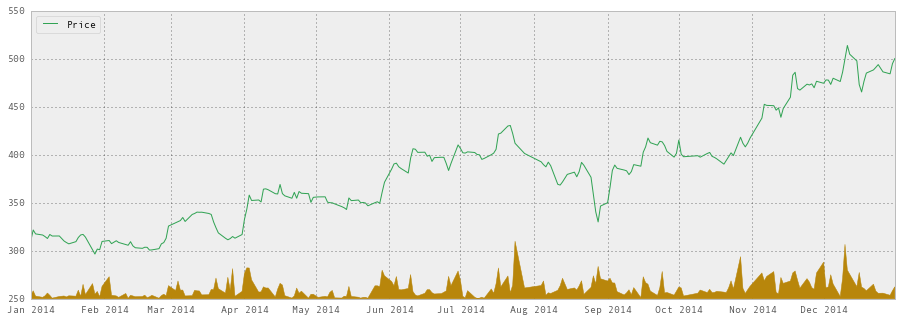

In [5]:
plot(stock)

## Moving Average

**Moving Average (MA)** smooths out price data by creating a constantly updated average price. The average is taken over a specific period of time, like 10 days, 20 minutes, 30 weeks, or any time period.

We'll calculate moving averages for the period of 20 and 50 days:

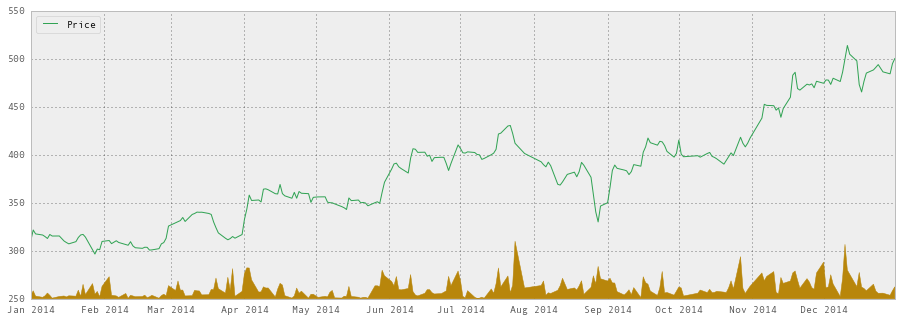

In [6]:
ma20 = pd.rolling_mean(stock.closing, window = 20)
ma50 = pd.rolling_mean(stock.closing, window = 50)


plot(stock, overlays = [
    #[ma20, {'label':'MA(20)', 'lw': 2}],
    #[ma50, {'label':'MA(50)', 'lw': 2}]
])

## Exponential Moving Average

A type of moving average that is similar to a simple moving average, except that more weight is given to the latest data.

#### Calculation:

**Multiplier:** (2 / (Time Periods + 1) )

**EMA:** {Close - EMA(previous day)} x Multiplier + EMA(previous day)

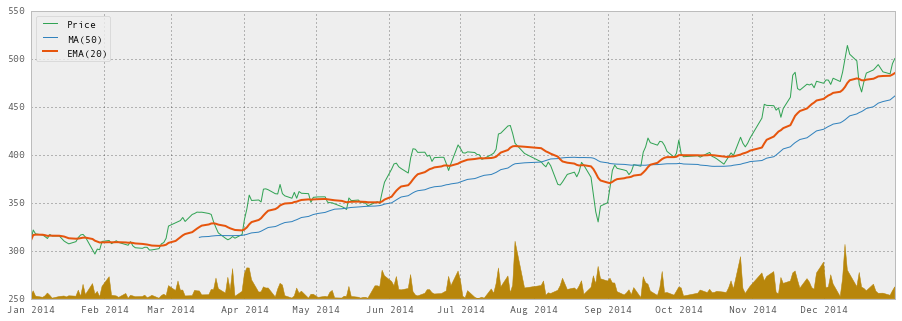

In [7]:
ema20 = pd.ewma(stock.closing, span = 20)

plot(stock, overlays = [
    [ma50, {'label':'MA(50)'}],
    [ema20, {'label':'EMA(20)', 'lw': 2}]
])

## Bollinger Bands 

Bollinger Bands are volatility bands placed above and below a moving average. Volatility is based on the standard deviation, which changes as volatility increases and decreases. The bands automatically widen when volatility increases and narrow when volatility decreases. 

#### Calculation:
**Middle Band** = 20-day simple moving average (SMA)

**Upper Band** = 20-day SMA + (20-day standard deviation of price x 2) 

**Lower Band** = 20-day SMA - (20-day standard deviation of price x 2)

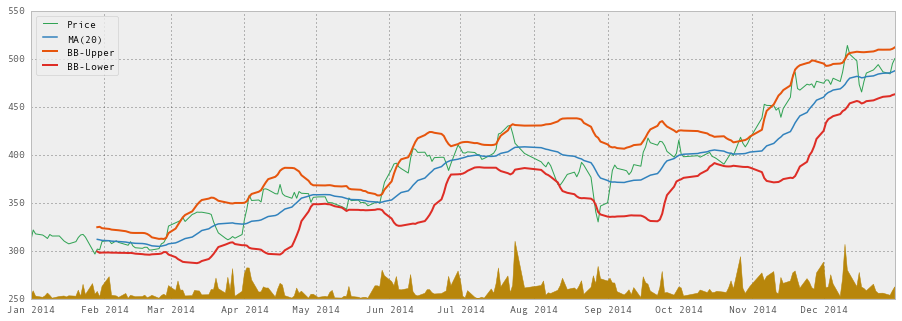

In [8]:
bb_upper = ma20 + 2 * pd.rolling_std(stock.closing, 20, min_periods=20)
bb_lower = ma20 - 2 * pd.rolling_std(stock.closing, 20, min_periods=20)

plot(stock, overlays = [
    [ma20, {'label':'MA(20)', 'lw': 1.5}],
    [bb_upper, {'label':'BB-Upper', 'lw': 2}],
    [bb_lower, {'label':'BB-Lower', 'lw': 2}]
])

## Price Channels 

Price Channels are lines set above and below the price of a security. 

**Upper Channel Line:** 20-day High

**Lower Channel Line:** 20-day Low

**Centerline:** (20-day High + 20-day Low)/2 

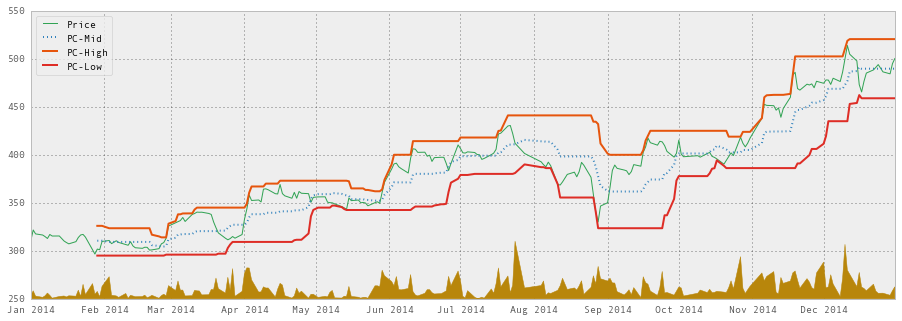

In [9]:
pc_high = pd.rolling_max(stock.high, window = 20)
pc_low = pd.rolling_min(stock.low, window = 20)
pc_mid = (pc_high + pc_low) / 2

plot(stock, overlays = [
    [pc_mid, {'label':'PC-Mid', 'linewidth': 2, 'ls':':'}],
    [pc_high, {'label':'PC-High', 'linewidth': 2}],
    [pc_low, {'label':'PC-Low', 'linewidth': 2}]
])

## Average True Range

The Average True Range (ATR) is an indicator that measures volatility.

#### Calculation:

First we determine our **true ranage (TR)**:

TR = MAX(High – Low, ABS(Hight – LDCP), ABS(LDCP – Low)) 

Then **ATR** at the moment of time $t$ is calculated using the following formula:

$$
ATR_t = \frac{ATR_{t-1} \times (n-1) + TR_t}{n}
$$

The first ATR value is calculated using the arithmetic mean formula:

$$
ATR = \frac{1}{n} \sum_{i=1}^{n} TR_i
$$


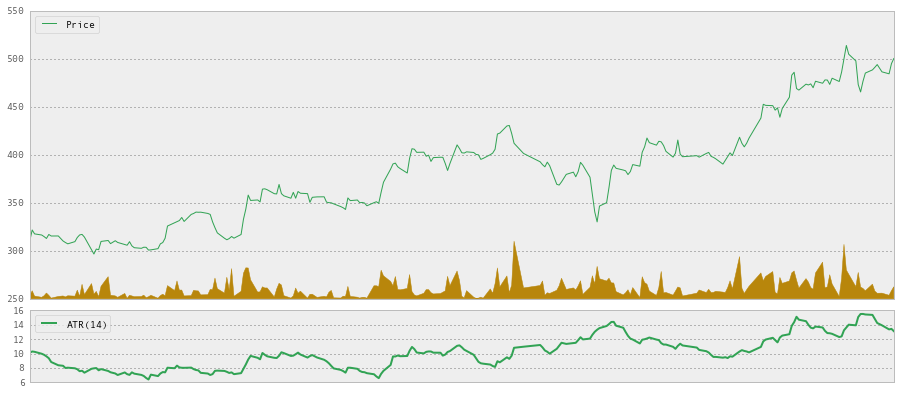

In [27]:
def wilders_moving_average(values, period = 30):
    k = 1 / period
    wma = values
    for x in range(1, len(values)):
        wma[x] = (values[x - 1] * (1 - k)) + (values[x] * k)
    
    return wma

def true_range(stock):
    tr = pd.DataFrame(index=stock.index, columns=['value'])
    
    lastRow = None
    count = 0
    for index, row in stock.iterrows(): # determining our True Range
        if count == 0:
            lastRow = row
            tr.ix[index]['value'] = (row.high - row.low)
            count += 1
        else :
            tr.ix[index]['value'] = max(row.high, lastRow.closing) - min(row.low, lastRow.closing)
            lastRow = row
    
    return tr

def average_true_range(stock, period = 14):
    tr = true_range(stock)

    atr = wilders_moving_average(tr.value, period)

    return atr

atr14 = average_true_range(stock)

plot(stock, subplots = [
   [atr14, {'label':'ATR(14)', 'lw': 2, 'c': '#e6550d'}]
])

## Keltner Channels 

Keltner Channels are volatility-based envelopes set above and below an exponential moving average. This indicator is similar to Bollinger Bands, which use the standard deviation to set the bands. Instead of using the standard deviation, Keltner Channels use the Average True Range (ATR) to set channel distance. 

**Middle Line:** 20-day exponential moving average 

**Upper Channel Line:** 20-day EMA + (2 x ATR(10))

**Lower Channel Line:** 20-day EMA - (2 x ATR(10))

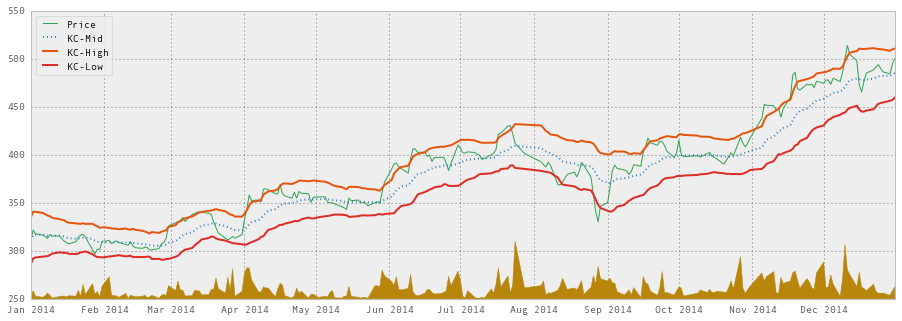

In [21]:
atr10 = average_true_range(stock, period = 10)
kc_high = ema20 + (2 * atr10.value)
kc_low = ema20 - (2 * atr10.value)

plot(stock, overlays = [
    [ema20, {'label':'KC-Mid', 'lw': 2, 'ls':':'}],
    [kc_high, {'label':'KC-High', 'lw': 2}],
    [kc_low, {'label':'KC-Low', 'lw': 2}]
])

## Parabolic SAR 

Parabolic SAR is a trend following system constantly tailing the price action. It is a time series of stop-level points, portrayed on the chart in the form of dots, plotted below or above each price mark. A dot placed below the price is deemed to be a **bullish** signal while a dot placed above the prices is considered to be a **bearish** indicator. 

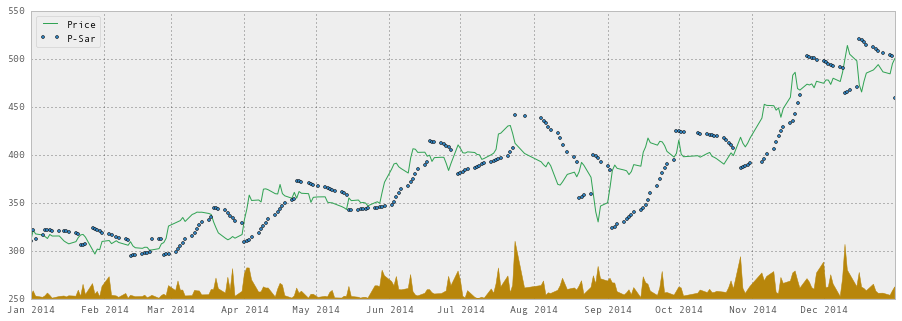

In [17]:
def psar(stock, iaf = 0.02, maxaf = 0.2):
    length = len(stock.index)
    dates = list(stock.index)
    high = list(stock.high.values)
    low = list(stock.low.values)
    close = list(stock.closing.values)
    psar = close[0:len(close)]

    bull = True
    af = iaf
    ep = low[0]
    hp = high[0]
    lp = low[0]
    for i in range(2,length):
        if bull:
            psar[i] = psar[i - 1] + af * (hp - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (lp - psar[i - 1])
        reverse = False
        if bull:
            if low[i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = hp
                lp = low[i]
                af = iaf
        else:
            if high[i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = lp
                hp = high[i]
                af = iaf
        if not reverse:
            if bull:
                if high[i] > hp:
                    hp = high[i]
                    af = min(af + iaf, maxaf)
                if low[i - 1] < psar[i]:
                    psar[i] = low[i - 1]
                if low[i - 2] < psar[i]:
                    psar[i] = low[i - 2]
            else:
                if low[i] < lp:
                    lp = low[i]
                    af = min(af + iaf, maxaf)
                if high[i - 1] > psar[i]:
                    psar[i] = high[i - 1]
                if high[i - 2] > psar[i]:
                    psar[i] = high[i - 2]

    return  pd.DataFrame({
            "dates":dates, 
            "high":high, 
            "low":low, 
            "close":close, 
            "psar":psar})

ps = psar(stock)

plot(stock, overlays = [
    [ps.psar, {'label':'P-Sar', 'lw': 3, 'ls':'', "marker":'o', "ms": 3}]
])

## Relative Strength Index 

A technical momentum indicator that compares the magnitude of recent gains to recent losses in an attempt to determine overbought and oversold conditions of an asset. It is calculated using the following formula:

**RSI = 100 - 100/(1 + RS*)**

_Where RS = Average of x days' up closes / Average of x days' down closes._

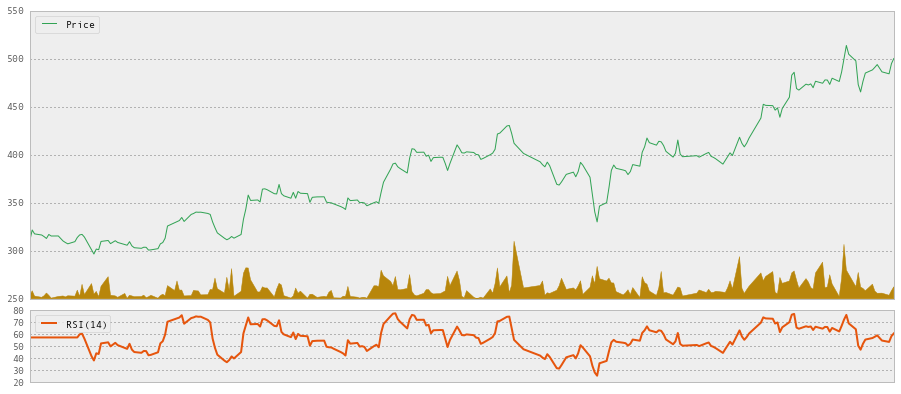

In [18]:
n = 14
deltas = np.diff(stock.closing.values)
seed = deltas[:n+1]
up = seed[seed>=0].sum()/n
down = -seed[seed<0].sum()/n

rs = up/down
rsi = np.zeros_like(stock.closing.values)

rsi[:n] = 100. - 100./(1.+rs)

for i in range(n, len(stock.closing.values)):
    delta = deltas[i-1] # cause the diff is 1 shorter

    if delta>0:
        upval = delta
        downval = 0.
    else:
        upval = 0.
        downval = -delta

    up = (up*(n-1) + upval)/n
    down = (down*(n-1) + downval)/n

    rs = up/down
    rsi[i] = 100. - 100./(1.+rs)

plot(stock, subplots = [
    [rsi, {'label':'RSI(14)', 'lw': 2, 'c': '#e6550d'}]
])

## Moving Average Convergence Divergence (MACD) 

Moving Average Convergence/Divergence oscillator (MACD) turns two trend-following indicators, moving averages, into a momentum oscillator by subtracting the longer moving average from the shorter moving average.

#### Calculation:

**MACD Line:** (12-day EMA - 26-day EMA)

**Signal Line:** 9-day EMA of MACD Line

**MACD Histogram:** MACD Line - Signal Line

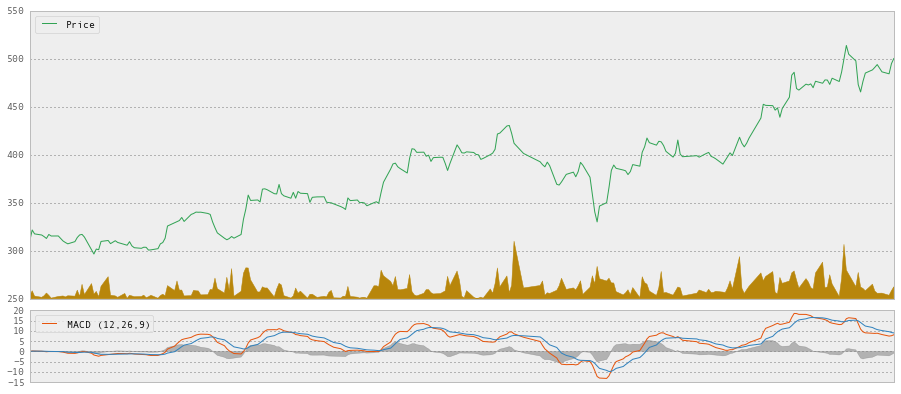

In [19]:
macd_line = pd.ewma(stock.closing, span = 12) - pd.ewma(stock.closing, span = 26)
macd_signal = pd.ewma(macd_line, span = 9)
macd_hist = macd_line - macd_signal

plot(stock, subplots = [
    [macd_line, {'label':'MACD (12,26,9)', 'lw': 1, 'c': '#e6550d'}],
    [macd_signal, {'lw': 1}],
    [macd_hist, {'lw': 1}, 'hist']
])

## Money Flow Index

The Money Flow Index (MFI) is an oscillator that uses both price and volume to measure buying and selling pressure.

#### Calculation

**Typical Price** = (High + Low + Close)/3

**Raw Money Flow** = Typical Price x Volume

**Money Flow Ratio** = (14-period Positive Money Flow)/(14-period Negative Money Flow)

**Money Flow Index** = 100 - 100/(1 + Money Flow Ratio)

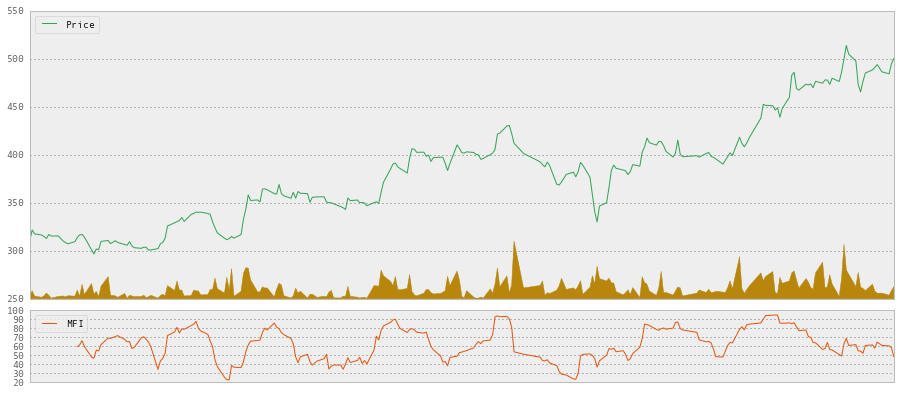

In [20]:
def money_flow_index(stock):
    typical_price = (stock.high + stock.low + stock.closing) / 3
    raw_money_flow = typical_price * stock.turnover
    change = stock.closing.pct_change()
    
    mf_pos = np.zeros_like(stock.closing.values)
    mf_neg = np.zeros_like(stock.closing.values)
    
    for i in range(1, len(typical_price)):
        if typical_price[i] > typical_price[i - 1]:
            mf_pos[i] = raw_money_flow[i]
        elif typical_price[i] < typical_price[i - 1]:
            mf_neg[i] = raw_money_flow[i]
    
    mf_pos_14 = pd.rolling_sum(mf_pos, window = 14)
    mf_neg_14 = pd.rolling_sum(mf_neg, window = 14)
    
    mf_ratio = mf_pos_14 / mf_neg_14
    
    return 100 - 100/(1 + mf_ratio)

mfi = money_flow_index(stock)

plot(stock, subplots = [
    [mfi, {'label':'MFI', 'lw': 1, 'c': '#e6550d'}],
])

## Directional Movement System (DMI/ADX) 

The Directional Movement System designed by Welles Wilder is composed of three indicators whose purpose is to help ascertain whether the market is trending and provide traders with signals for trading the trend. The system consists of three lines:

- The **Positive Direction Indicator (+DI)**, summarizes upward trend direction
- The **Negative Direction Indicator (-DI)**, summarizes downward trend direction
- The **Average Directional Movement Index (ADX)**, which indicates the degree of trend strength

We'll start with calculating Directional Indicator **(DI+/DI-)**. First we need to calculate Directional Movement **(DM+, DM-)**. The calculations are as follows:

```
Today’s High - Yesterdays High = X
Yesterday’s Low - Today’s Low  = Y
```

Three Potentials outcomes are:
```
Values	     Outcomes
X and Y < 0   +DM=0, -DM=0
X > Y	     +DM=X, -DM=0
X < Y	     +DM=0, -DM=Y
```

Next is to calculate 14-period **Wilders exponential moving average (WEMA)** of **DM+**, **DM-** and **TR (True Range)**:

```
+DM14 = WEMA of +DM14  
-DM14  = WEMA of –DM14  
TR14  = WEMA of TR14
```

Finally for **Directional Indicators (DI+/DI-)**:

```
+DI14 =+DM14/TR14 * 100
-DI14  = -DM14/TR14 * 100
```

To calculate ADX:
```
DI Difference = The Absolute value of the difference between +DI14 and –DI14
Directional Index (DX) = DI Difference divided by the sum of +DI14 and –DI14
ADX = EMA of DX * 100
```

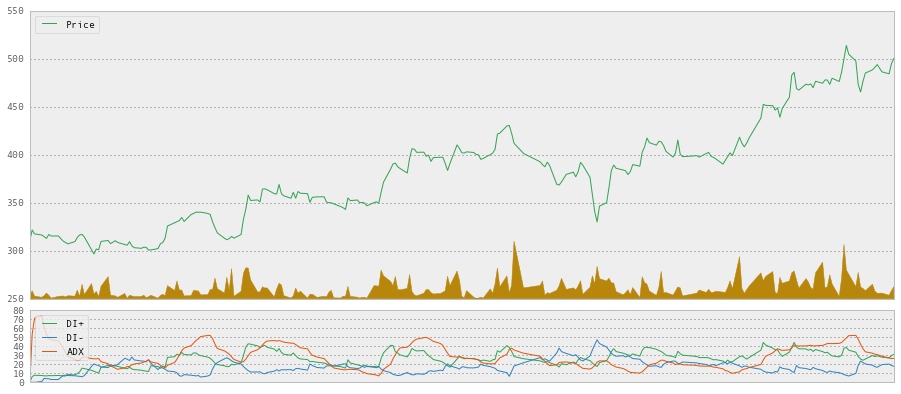

In [139]:
def directional_movements(stock):
    tr = pd.DataFrame(index=stock.index, columns=['value'])
    
    dm_pos = np.zeros_like(stock.closing.values)
    dm_neg = np.zeros_like(stock.closing.values)
    
    for i in range(1, len(stock)):
        x = stock.ix[i]['high'] - stock.ix[i - 1]['high']
        y = stock.ix[i - 1]['low'] - stock.ix[i]['low']
        
        if x > y:
            dm_pos[i] = x
        elif x < y:
            dm_neg[i] = y
    
    dm_pos_14 = wilders_moving_average(dm_pos, period = 14)
    dm_neg_14 = wilders_moving_average(dm_neg, period = 14)
    tr_14 = average_true_range(stock, period = 14)
    
    di_pos_14 = (dm_pos_14 / tr_14) * 100
    di_neg_14 = (dm_neg_14 / tr_14) * 100

    di_diff = abs(di_pos_14 -  di_neg_14)
    di_sum = di_pos_14 + di_neg_14
    di_sum[di_sum==0] = 0.1
    dx = di_diff / di_sum
    adx = pd.ewma(dx, span=14) * 100
    return {
        'di_pos': di_pos_14,
        'di_neg': di_neg_14,
        'adx': adx
    }
          
dmi = directional_movements(stock)
plot(stock, subplots = [
    [dmi['di_pos'], {'label':'DI+', 'lw': 1}],
    [dmi['di_neg'], {'label':'DI-', 'lw': 1}],
    [dmi['adx'], {'label':'ADX', 'lw': 1}]
])

## Rate of Change (ROC) 

The Rate-of-Change (ROC) indicator, which is also referred to as simply Momentum, is a pure momentum oscillator that measures the percent change in price from one period to the next. The ROC calculation compares the current price with the price “n” periods ago.

#### Calculation:
```
ROC = [(Close - Close n periods ago) / (Close n periods ago)] * 100
```

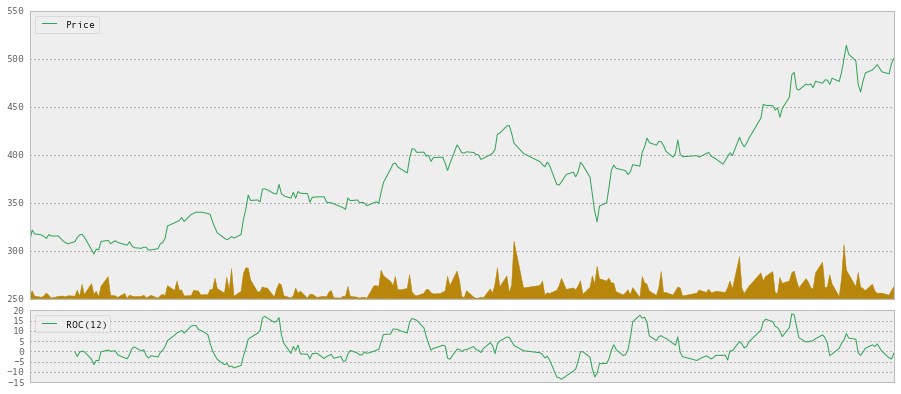

In [152]:
def roc(period):
    n = len(period) - 1
    return ((period[n] - period[0]) / period[0]) * 100

roc_12 = pd.rolling_apply(stock.closing, 13, roc)

plot(stock, subplots = [
    [roc_12, {'label':'ROC(12)', 'lw': 1}]
])

## Commodity Channel Index (CCI)

Commodity Channel Index (CCI) is used to identify a new trend or warn of extreme conditions. CCI is relatively high when prices are far above their average. CCI is relatively low when prices are far below their average. In this manner, CCI can be used to identify overbought and oversold levels.

#### Calculation:
```
CCI = (Typical Price  -  20-period SMA of TP) / (.015 x Mean Deviation)

Typical Price (TP) = (High + Low + Close)/3

Constant = .015

There are four steps to calculating the Mean Deviation. First, subtract 
the most recent 20-period average of the typical price from each period's 
typical price. Second, take the absolute values of these numbers. Third, 
sum the absolute values. Fourth, divide by the total number of periods (20). 
```

In [169]:
def commodity_channel_index(stock, period = 20):
    typical_price = (stock.high + stock.low + stock.closing) / 3
    
    sma_tp = pd.rolling_mean(typical_price, window = period)
    sma_tp_diff = abs(typical_price - sma_tp)
    mean_dev = pd.rolling_sum(sma_tp_diff, window = period) / period
    
    return (typical_price - sma_tp) / (0.015 * mean_dev)
    
commodity_channel_index(stock)

2014-01-01           NaN
2014-01-02           NaN
2014-01-03           NaN
2014-01-06           NaN
2014-01-07           NaN
2014-01-08           NaN
2014-01-09           NaN
2014-01-10           NaN
2014-01-13           NaN
2014-01-15           NaN
2014-01-16           NaN
2014-01-17           NaN
2014-01-20           NaN
2014-01-21           NaN
2014-01-22           NaN
2014-01-23           NaN
2014-01-24           NaN
2014-01-27           NaN
2014-01-28           NaN
2014-01-29           NaN
2014-01-30           NaN
2014-01-31           NaN
2014-02-03           NaN
2014-02-04           NaN
2014-02-06           NaN
2014-02-07           NaN
2014-02-10           NaN
2014-02-11           NaN
2014-02-12           NaN
2014-02-13           NaN
                 ...    
2014-11-19    157.027297
2014-11-20     93.845416
2014-11-21     72.044737
2014-11-24     69.311062
2014-11-25     54.983186
2014-11-26     54.212161
2014-11-27     37.833045
2014-11-28     45.673516
2014-12-01     35.859703


In [168]:
talib.CCI(stock.high.values, stock.low.values, stock.closing.values, timeperiod=20)

array([          nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan,           nan,
                 nan,           nan,           nan, -176.87860715,
       -146.12971908,  -54.77095305,    8.10059669,  -34.42154596,
          4.53752836,  -19.85657859,  -83.41415089,  -40.03352044,
         11.03015584,  -46.457828  ,  -67.48208089,  -64.58674114,
        -61.87595987,  -46.96886947,  -86.29254456,  -54.66108586,
        -44.01585215,  -13.61424984,   67.29587062,  122.3366374 ,
        295.64332658,  295.7810679 ,  254.48338198,  189.8260541 ,
        174.8605558 ,  125.70145543,  125.20590556,  125.12804009,
        114.54371545,  100.08056787,   89.52102276,   80.10071169,
         65.7748448 ,   32.96344086,   -0.85887855,  -48.51933108,
       -100.11399974, -128.48785773, -124.35459876, -111.02020